In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
import glob
import os

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [57]:
def simple_pendulum_deriv(x, t, m, g, l): 
    
    nx = np.zeros(2)
    nx[0] = x[1]
    nx[1] = -(m * g * l * np.sin(x[0])) 
    return nx

def plot_orbit( x0 ):
    """
    Plot the phase space of the pendulum

    """
    # Pick ts to be sufficiently large (by inspection) to make sure
    # that all of the cases of interest will have reached their 
    # homoclinic orbit
    ts = np.linspace(0.0, 50.0, 1001)
    ys = odeint(simple_pendulum_deriv, x0, ts, args = (1.0, 9.8, 1.0))
    plt.plot(ys[:,0], ys[:,1])

#def plot_pendulum(q, length = 1.0):
#    xs = [ 0.0,  length * np.sin(q[0]) ]
#    ys = [ 0.0, -length * np.cos(q[0]) ]
#    plt.plot( xs, ys, 'b-', linewidth = 3 )
#    plt.plot( xs[1], ys[1], 'ro' )
#    plt.gca().set_xlim([-1.2, 1.2])
#    plt.gca().set_ylim([-1.2, 1.2])
#    plt.gca().set_aspect('equal')

def plot_interesting_orbits():
    plt.clf()

    plot_orbit(np.array([np.pi * 0.25, 0.0]))
    plot_orbit(np.array([np.pi * 0.5, 0.0]))
    plot_orbit(np.array([np.pi * 0.9, 0.0]))
    plot_orbit(np.array([np.pi * 0.999, 0.0]))
    plot_orbit(np.array([np.pi * -5.0, 2.5]))
    plot_orbit(np.array([np.pi * 5.0, -2.5]))
    plot_orbit(np.array([np.pi * -5.0, 5.0]))
    plot_orbit(np.array([np.pi * 5.0, -5.0]))
    plt.title('homoclinic orbits for an undamped simpled pendulum')
    plt.xlim([-3.5,3.5])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\dot{\theta}$')
    plt.show()

In [3]:
def pendulum_video( q0, ts, output_file):
    ts = np.linspace(0.0, 5.0, 101)
    qs = odeint(simple_pendulum_deriv, q0, ts, args = (1.0, 9.8, 1.0))
    pendulum_video_sequence(qs, output_file)

def encode_video(input_pattern, output_filename):
    # taken (almost) directly from the matplotlib website:
    # http://matplotlib.sourceforge.net/faq/howto_faq.html#make-a-movie
    os.system("mencoder 'mf://%s' -mf type=png:fps=10 -ovc lavc -lavcopts vcodec")

def pendulum_video_sequence(qs, output_filename):
    for n, q in enumerate(qs):
        print(n, q)
        plt.clf()
        plot_pendulum( q )
        plt.savefig( '_tmp%03d.png' % n )
    encode_video('_tmp*.png', output_filename)
    for fname in glob.glob('_tmp*.png'):
        os.remove(fname)

def interesting_videos():
    ts = np.linspace(0.0, 50.0, 501)
    pendulum_video( np.array([np.pi/2.0, 0.0]), ts, 'undamped_simple_pendulum01.mp4' )
    pendulum_video( np.array([3*np.pi/4.0, 0.0]), ts, 'undamped_simple_pendulum02.mp4' )

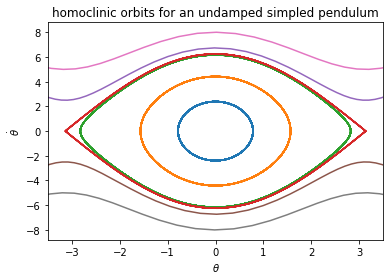

In [58]:
plot_interesting_orbits()

0 [1.57079633 0.        ]
1 [ 1.55854639 -0.48999258]
2 [ 1.52180025 -0.97976467]
3 [ 1.46059098 -1.46821495]
4 [ 1.37504685 -1.95249444]
5 [ 1.26549931 -2.42719982]
6 [ 1.13262774 -2.88373423]
7 [ 0.97762824 -3.31001789]
8 [ 0.80238331 -3.69078623]
9 [ 0.6095972 -4.0086933]
10 [ 0.40285396 -4.24628516]
11 [ 0.18655939 -4.38861066]
12 [-0.03425227 -4.42589002]
13 [-0.25423002 -4.35545653]
14 [-0.46808229 -4.18231155]
15 [-0.67094081 -3.91809245]
16 [-0.8586398  -3.57882216]
17 [-1.02786733 -3.18217897]
18 [-1.17618417 -2.7450363 ]
19 [-1.30193714 -2.28175006]
20 [-1.40410875 -1.80332159]
21 [-1.48214457 -1.31730774]
22 [-1.53578995 -0.82824222]
23 [-1.56495572 -0.33834258]
24 [-1.5696229   0.15165624]
25 [-1.54979039  0.64162794]
26 [-1.50546657  1.13117331]
27 [-1.4367049   1.61874132]
28 [-1.34368314  2.10077362]
29 [-1.22682351  2.57093471]
30 [-1.08694666  3.01955817]
31 [-0.92544382  3.43351274]
32 [-0.74444008  3.7967302 ]
33 [-0.54691054  4.0915828 ]
34 [-0.33670602  4.30109521]

sh: mencoder: command not found


1 [ 2.34751994 -0.34748101]
2 [ 2.32134712 -0.70091106]
3 [ 2.27723405 -1.06601187]
4 [ 2.21446412 -1.44799154]
5 [ 2.13208128 -1.85113851]
6 [ 2.02894984 -2.27823485]
7 [ 1.90384914 -2.7297386 ]
8 [ 1.75561542 -3.20272175]
9 [ 1.58334152 -3.68963606]
10 [ 1.38663844 -4.17713069]
11 [ 1.16594604 -4.64535944]
12 [ 0.92285309 -5.06841481]
13 [ 0.66035352 -5.41653857]
14 [ 0.38294099 -5.66035847]
15 [ 0.09645181 -5.77652082]
16 [-0.19237579 -5.75306234]
17 [-0.47656052 -5.59244322]
18 [-0.74959932 -5.31090839]
19 [-1.00606735 -4.93446625]
20 [-1.24196635 -4.49319902]
21 [-1.45479049 -4.01595705]
22 [-1.64336674 -3.52677767]
23 [-1.80756727 -3.04332398]
24 [-1.94798605 -2.57690364]
25 [-2.06564168 -2.13338696]
26 [-2.16173597 -1.71444404]
27 [-2.23747446 -1.31873736]
28 [-2.29394164 -0.94290507]
29 [-2.33201913 -0.58229774]
30 [-2.35233511 -0.23149848]
31 [-2.35523545  0.1153177 ]
32 [-2.34077013  0.46412388]
33 [-2.30869139  0.8208204 ]
34 [-2.25846312  1.1909945 ]
35 [-2.18928414  1.5796

sh: mencoder: command not found


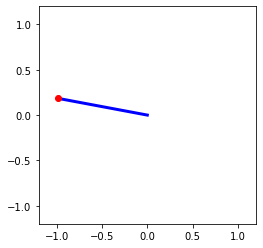

In [5]:
interesting_videos()